# **Conceptual Model approach 1-4**

In [1]:
import matplotlib.pyplot as plt
import os, re
import numpy as np
import flopy as fp
import geopandas as gpd

from definitions import ROOT_DIR, FLOPY_EXEC, FLOPY_MF_FILES
from utils.flopy_utils import model_map, features_intersect
from utils.io import dataframe_viewer, dict_viewer, geodf_map

### TODO:
- find how to resample a LineString, Polygon surface and boundary (based on grid cell size) --> border limits cells to set boundary conditions
- intersect 3D geometries (vtk objects)

# Initial settings

In [2]:
model_name = "mf6_test-1"
model_files = f"{model_name}_files"

In [3]:
MF_DIR = f"{FLOPY_MF_FILES}/{model_files}"
if os.path.isdir(MF_DIR): 
    os.system(f'rm -fr {MF_DIR}')

# 1. Reading of shapefiles/geopackages

In [4]:
gis_dir = f'{ROOT_DIR}/qgis/'
gis_files = [p+'/'+f for p, d, fl in os.walk(gis_dir) for f in fl if f.split('.')[1] in ['gpkg', 'shp']]
assert gis_files # check if files list is not empty
gis_names = list([re.sub(f'.+/|\\.gpkg$|\\.shp$', '', txt) for txt in gis_files])
print(gis_names)

['AOI_boundary', 'Sambre-River', 'Area_of_interest', 'MNT_points', 'Galeries', 'Parties_exploitees', 'Shaft', 'Galeries', 'Parties_exploitees', 'Shaft', 'example', 'Digitalized']


In [5]:
k = 7 # number of files to keep
gdfs = [gpd.read_file(shp) for shp in gis_files[:k]]
geom_type = [list(set(gdf.geometry.geom_type))[0] for gdf in gdfs[:k]]

gis_dict = {'data':gdfs, 'name':gis_names[:k], 'geom_type':geom_type}

In [6]:
for n, x in enumerate(gis_dict['data']):
    for c in x.columns: # erase ' ' at the end of columns names
        x.rename(columns={f'{c}':c.rstrip(' ')}, inplace=True)   
    if n < len(gis_names): print(n, gis_dict['name'][n], ':\t', x.columns, len(x))

0 AOI_boundary :	 Index(['point_id', 'geometry'], dtype='object') 925
1 Sambre-River :	 Index(['id', 'geometry'], dtype='object') 1
2 Area_of_interest :	 Index(['id', 'geometry'], dtype='object') 1
3 MNT_points :	 Index(['point_id', 'geometry'], dtype='object') 31764
4 Galeries :	 Index(['Type', 'Profondeur', 'geometry'], dtype='object') 761
5 Parties_exploitees :	 Index(['Année', 'Couche', 'geometry'], dtype='object') 850
6 Shaft :	 Index(['Nom', 'Début ou fin', 'geometry'], dtype='object') 34


In [7]:
data_name = 'MNT_points'
gdf = gis_dict['data'][gis_dict['name'].index(data_name)]
dataframe_viewer(gdf, rows=5)

Rows : 31764, columns : 2


/home/yanathan/.local/share/virtualenvs/Geotherma-DQtWNVFx/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=5, description='rows', max=31764, min=5, readout=False), IntSlider(value…

In [8]:
data_name = 'Galeries'
n=gis_dict['name'].index(data_name)
col = 'Type'
to_find = ['^[b|B]ouv', '[l|L]ie.?$', 'Lien bou', '[v|V]oi.?',]
repl_with = ['Bouveau', 'Lien', 'Lien bouveaux', 'Voie']

for i, x in enumerate(to_find):
    new_val = ''
    qry = gis_dict['data'][n].query(f'{col}.str.contains("{x}")')[col]
    if len(set(qry))>1:
        if repl_with is None: 
            print('\nmany values', set(qry))
            new_val = input('uniform with (Enter if no change):')
        else:
            new_val = repl_with[i]
            print(f'\nmany values {set(qry)} have been replaced by : \'{new_val}\'')
        if len(new_val)>0:
            gis_dict['data'][n].loc[qry.index, col] = new_val.capitalize()
print('\n--> Results :', set(gis_dict['data'][n][col]))


many values {'Bouvea', 'Bouveau', 'Bouveau '} have been replaced by : 'Bouveau'

many values {'Lieb', 'Lien'} have been replaced by : 'Lien'

many values {'Lien bouveaux', 'Lien bouveau '} have been replaced by : 'Lien bouveaux'

many values {'Voie', 'Voie '} have been replaced by : 'Voie'

--> Results : {'Bouveau', 'Lien', 'Voie', 'Lien Veines', 'Recoutelage', 'Burquin', 'lien ', 'Lien bouveaux'}


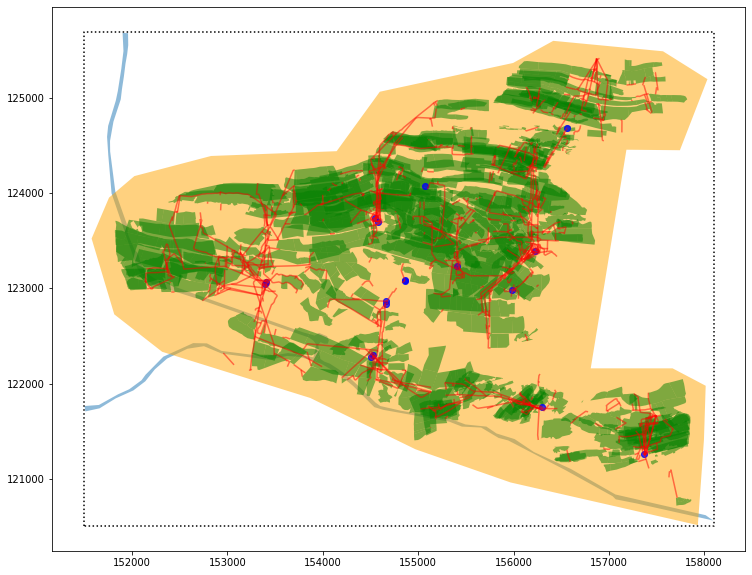

((6609.177353579958, 5181.824364191474),
 [(151492.0264037754, 158101.20375735537),
  (120508.40492641728, 125690.22929060875)])

In [9]:
colors = [None, 'orange', 'red', 'green', 'blue', 'royalblue']
# i don't add MNT points (because of loading time !!!)
data_sel = [gis_dict['data'][gis_dict['name'].index(i)] for i in gis_dict['name'] 
            if i not in ['MNT_points', 'AOI_boundary']] 

area_bbox, area_lw = geodf_map(data_sel, plot=True, _return=True, expand=(10, 10), 
                               colors=colors, figsize=(20,10))
area_lw, area_bbox

* Saving geopackage to shapefile

#### Retrieve each feature ('line', 'point', 'polygon') min/max coordinates

In [10]:
min_max_dict = {} # coordinates min/max per file
ftr_z = {} # keep all rounded Z per file
for n in range(len(gis_dict['data'])):
    data = gis_dict['data'][n]
    points = []
    print(gis_dict['geom_type'][n])
    for i in data.index:
        ftr = data.geometry[i] # linestring
        cd_txt = ftr.wkt[ftr.wkt.find('('):].strip('()') # coords extraction as string
        for cd in cd_txt.split(', '):
            p = cd.split(' ')
            points.append([float(i) for i in p])
            
    xmin = np.nanmin([p[0] for p in points])
    xmax = np.nanmax([p[0] for p in points])
    ymin = np.nanmin([p[1] for p in points])
    ymax = np.nanmax([p[1] for p in points])
    zmin = np.nanmin([p[2] if len(p)==3 else 0 for p in points]) # Z can be negative !!
    zmax = np.nanmax([p[2] if len(p)==3 else 0 for p in points])
    
    z = list(set([round(p[2]) if len(p)==3 else 0 for p in points]))
    ftr_z.update({gis_dict['name'][n]: z})
    min_max_dict.update({gis_dict['name'][n]: [(xmin, ymin, min(zmin, zmax)), (xmax, ymax, max(zmin, zmax))]})

Point
Polygon
Polygon
Point
LineString
Polygon
Point


In [11]:
dict_viewer(min_max_dict)

AOI_boundary,"[(151579.41647119977, 120507.02364887949, 0), (158031.57427230346, 125603.26756411791, 0)]"
Sambre-River,"[(151502.0264037754, 120567.64889461585, 0.0), (158091.20375735537, 125680.22929060875, 0.0)]"
Area_of_interest,"[(151576.07360843688, 120518.40492641728, 0.0), (158033.44797526105, 125596.62295746995, 0.0)]"
MNT_points,"[(151579.41647119977, 120537.89128106274, 85.0), (158011.93574943132, 125572.51951502915, 224.0)]"
Galeries,"[(152137.62264056425, 120804.60895671032, -1070.5), (157716.27208650328, 125414.08144693852, 121.0)]"
Parties_exploitees,"[(151819.84956436296, 120722.49326382068, -1078.3), (157866.28669802073, 125401.77885709287, 144.0)]"
Shaft,"[(153391.94, 121261.4879999999, -1063.4), (157366.95900000018, 124685.816, 155.39)]"


(array([0., 0., 1., 0., 0.]),
 array([-0.5, -0.3, -0.1,  0.1,  0.3,  0.5]),
 <BarContainer object of 5 artists>)

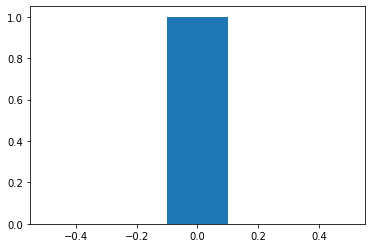

In [12]:
# statistical approach for vertical discretization (not based on geology !)
plt.hist([x for x in ftr_z.values()][2], bins=5) # histogram of Z

# 2. Model building and simulation

## Create MODFLOW6 components for a simulation

#### Create a simulation object (SIM)

In [13]:
sim = fp.mf6.MFSimulation(sim_name=model_name, exe_name=f"{FLOPY_EXEC}/mf6", version="mf6", sim_ws=MF_DIR)

#### Create a temporal discretization object (TDIS)

In [14]:
#simulation of 366 days divided in 12 stress periods of 30 days, each stress period is divided in 3 time steps
#there is a steady state stress period at the beginning of the simulation

nper = 12 # nper = 1 --> if only steady-state simulation
perlen = np.ones(nper)
perlen[0] = 1
perlen[1:] = 30 * 86400 # time unit : second

#Definition of time steps
nstp = np.ones(nper) 
nstp[0] = 1 # first step is steady-state
nstp[1:] = 3

#Definition of stress period type: transient or steady state
periodType = np.zeros(nper, dtype=bool)
periodType[0] = True # steady-sate

#perdata = [(i,int(j),1) for i, j in zip(perlen, nstp)] # for transient
perdata = [(1., 1, 1.)] # for steady-state

In [15]:
tdis = fp.mf6.ModflowTdis(sim, pname="tdis", time_units="seconds", nper=1, perioddata=perdata)

#### Create an iterative model solution object (IMS)

In [16]:
ims = fp.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE", linear_acceleration="BICGSTAB")

#### Create a groundwater flow model object (GWF)

In [17]:
nam_file = f"{model_name}.nam"
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name, model_nam_file=nam_file, save_flows=True, 
                           newtonoptions="NEWTON UNDER_RELAXATION",)

## Add internal packages to GWF (internal flow of the system)

#### Model's parameters

In [18]:
# aquifer geometry (grid) [units in meters]
cw = 20 # cells number for a side
lth = 55 # constant layer thick
aq_th = 1235 # model global thickness
top = 156 # aquifer top
botm = np.arange((top-lth), -aq_th, -lth)   # bottom elevation for each cell/layer
Nlay = botm.shape[0] # number of layers 
delrow, delcol = np.round((np.array(area_lw)+cw)/cw) # column and row spacing (enlarge models sides with 50 m)
Nc, Nr = np.int_(np.round(np.array(area_lw)/[delrow, delcol])) # number of columns and rows (subdivisions)

# units
lu, tu = 'METERS', 'DAYS'

#### discretization (DIS) Package

In [19]:
dis = fp.mf6.ModflowGwfdis(gwf, nlay=Nlay, nrow=Nr, ncol=Nc, delr=delrow, delc=delcol, top=top, botm=botm, 
                           length_units='METERS')

In [20]:
gwf.modelgrid.set_coord_info(xoff=area_bbox[0][0], yoff=area_bbox[1][0], epsg=31370)

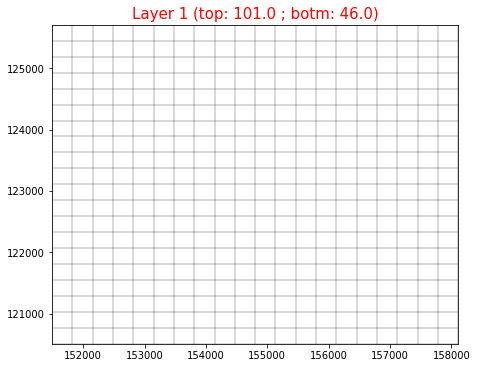

In [21]:
model_map(model=gwf, layer_line=1)

#### initial conditions (IC) Package

In [22]:
h0 = 1. # starting water head
start = h0 * np.ones((Nlay, Nr, Nc)) # creation of 3D vector filled with h1 to represent starting head

In [23]:
ic = fp.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

#### node property flow (NPF) Package

In [24]:
icelltype = np.zeros(Nlay)
kh = np.ones(Nlay)*5e-7 # horizontal hydraulic conductivity [m/s]
icelltype[0], kh[0] = 1, .001
kv = 2e-3 # vertical hydraumic conductivity

npf = fp.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=kh, k33=kh) # set cells properties
# icelltype = 1 --> cell is convertible ; 0 --> cell is confined

#### storage (STO) Package

## Retrieve all nodes coordinates like [node, (lrc), (xyz)]

In [25]:
cells_coords = features_intersect(gwf)

No data, only returns model cells coordinates
 The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


In [26]:
cells_coords[:5], f'Total_cells: {len(cells_coords)}'

([[9980, (24, 19, 0), (151657.5264037754, 120638.40492641728, -1191.5)],
  [9960, (24, 18, 0), (151657.5264037754, 120898.40492641728, -1191.5)],
  [9940, (24, 17, 0), (151657.5264037754, 121158.40492641728, -1191.5)],
  [9920, (24, 16, 0), (151657.5264037754, 121418.40492641728, -1191.5)],
  [9900, (24, 15, 0), (151657.5264037754, 121678.40492641728, -1191.5)]],
 'Total_cells: 10000')

## Intersection of the model with shapefiles

In [27]:
colors = [None, 'orange', 'red', 'yellow-green', 'blue', 'royalblue']
data_sel = [gis_dict['data'][gis_dict['name'].index(i)] for i in gis_dict['name'] 
            if i not in ['MNT_points', 'AOI_boundary']] 
geodf_map(data_sel, inter_plot=True, colors=colors, layers_name=gis_names)

#### Gridgen object (manipulation of spatial data)

In [28]:
gdg = fp.utils.gridgen.Gridgen(gwf.dis, exe_name=f"{FLOPY_EXEC}/gridgen", model_ws=MF_DIR, 
                               surface_interpolation='replicate')
gdg.build()

#### Set the IDOMAIN (area of interest)

In [29]:
print(gis_dict['name'])

['AOI_boundary', 'Sambre-River', 'Area_of_interest', 'MNT_points', 'Galeries', 'Parties_exploitees', 'Shaft']


In [30]:
data_name = 'MNT_points'
n=gis_dict['name'].index(data_name)
idom_cells = features_intersect(gwf, gridgen=gdg, data=gis_dict['data'][n], layer=0) # intersection with a specific data

 The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


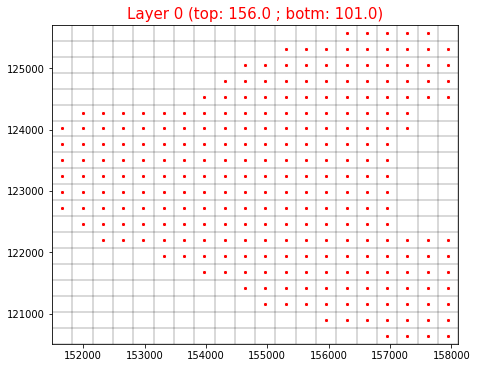

In [31]:
annotations = dict(coords=idom_cells, marker=['x', 'r', 5]) #text=[10, 'r'])
model_map(gwf, annotations=annotations, layer_line=0)

In [32]:
mgrid = gwf.modelgrid
nnodes = mgrid.nnodes
inactiv_nodes, idom_nodes, idom_array = [], [], []

for l in range(Nlay):
    for x in idom_cells:
        idom_nodes.append(tuple([l]) + x[1][1:]) #(lrc)
idom_nodes = mgrid.get_node(idom_nodes)

for n in range(nnodes):
    if n not in idom_nodes: 
        idom_array.append(0)
        inactiv_nodes.append(n)
    else: 
        idom_array.append(1)
inactiv_nodes = list(set(inactiv_nodes))

print(f'Total nodes: {nnodes} [inactive: {len(inactiv_nodes)} | active: {nnodes - len(inactiv_nodes)}]')

Total nodes: 10000 [inactive: 3400 | active: 6600]


In [33]:
gwf.dis.idomain = idom_array
mgrid = gwf.modelgrid

In [34]:
mgrid.idomain[0] # first layer idomain

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1,

#### get nodes at the idomain borders

In [35]:
print(gis_dict['name'])

['AOI_boundary', 'Sambre-River', 'Area_of_interest', 'MNT_points', 'Galeries', 'Parties_exploitees', 'Shaft']


In [36]:
range(gdg.get_nlay())

range(0, 25)

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import flopy as fp
import warnings
import os
from shapely.geometry import Point, Polygon, LineString
from flopy.utils.gridgen import Gridgen


def features_intersect(model, data=None, layer=None, local=False, intersect=True, surf_intersect=True, gridgen=None, verbose=False):
    """
        Intersects a feature ('point', 'line', 'polygon') with a model grid or returns all model grid
        cells nodes coordinates

        Parameters
        ------------
        model : Modflow.model object
            a gwf or gwt model
        data : list
            list of (shp or gpkg files, GeoDataFrame or shapely.geometry objects)
        layer : int or list
            force feature intersection with specific layer(s)
        local : bool
            if True, use cells local coordinates
        intersect : bool
            if True, intersect model grid with features list in 'data'; 
            if False, simply returns all model grid nodes coordinates
        surf_intersect: bool
            if True, polygon's surface is considered for the intersection
        gridgen: flopy.utils.gridgen.Gridgen object

        returns
        --------
        node_coords (list): list of intersected cells nodes coordinates like [node, (l,r,c), (x,y,z)]
    """

    mgrid = model.modelgrid
    intv = np.unique(mgrid.top_botm)[::-1]
    if data is None:
        print("No data, only returns model cells coordinates")
        intersect = False

    def _cells_coordinates(mgrid, local):
        xyz = mgrid.xyzcellcenters
        cells_coords = [[mgrid.get_node(mgrid.intersect(x, y, z, local=local))[0],
                         mgrid.intersect(x, y, z, local=local), (x, y, z)] for z in np.unique(xyz[2])
                        for x in np.unique(xyz[0]) for y in np.unique(xyz[1])]
        return cells_coords

    def _polygon_process(ftr, gridgen, layer, verbose):
        isect_nodes = []  # intersected nodes number
        isect_lay = []
        points = [i for i in ftr.exterior.coords]
        maxdepth = np.nanmin([p[2] for p in points])  # max depth reached by one of the feature elements

        # set layer(s) to intersect
        if layer is not None:
            layer = list(layer) if not isinstance(layer, (int, float)) else [layer]
        else:
            layer = range(gridgen.get_nlay())
            
        for lk in layer:
            try:
                nodes = list(gridgen.intersect(features=[ftr], featuretype=ftr.type.lower(), layer=lk))
            except Exception:
                print(f'intersection issue for model layer {lk}')
            
            if nodes and lk not in isect_lay: isect_lay.append(lk)
            for node in nodes:
                isect_nodes.append(node[0])
        
        isect_lay = list(set(layer).symmetric_difference(set(isect_lay)))
        print(f"intersected layers are")
        if verbose: print(f'Total of {len(isect_nodes)} cells intersected in following Layers : {isect_lay}')
        return isect_nodes

    def _process(feature, nodes_list, gridgen, surf_intersect, layer, verbose):
        gdg_msg = "A gridgen is needed to intersect surfaces. If None, set polygon_intersect='border'"
        coords = []
        if isinstance(feature, Polygon):
            if not surf_intersect:
                coords = feature.exterior.coords[:]
            else:
                assert isinstance(gridgen, Gridgen), gdg_msg
                nodes_list.extend(_polygon_process(feature, gridgen, layer, verbose))
        else:
            coords = feature.coords[:]

        for p in coords:
            if len(p) == 3:
                x, y, z = p
            elif len(p) == 2:
                x, y = p
                z = 0
            else:
                # case with M values
                pass

            if layer is not None:
                for i in range(len(intv) - 1):
                    if i == layer:
                        z = np.mean([intv[i], intv[i + 1]])
                        break

            lrc = [mgrid.intersect(x, y, z, local=local)]
            nodes_list.append(mgrid.get_node(lrc)[0])
        return nodes_list

    def _intersect(mgrid, data, layer, local, surf_intersect, verbose):
        d_msg = 'Only shp or gpkg files, GeoDataFrame or Point, LineString, Polygon objects are allowed'

        gdf_list, plp_list, gdf_nodes = [], [], []
        assert data is not None, 'Data not given'
        if not isinstance(data, list):
            data = [data]

        for dat in data:
            assert isinstance(dat, (str, Point, LineString, Polygon, gpd.GeoDataFrame)), d_msg
            if isinstance(dat, str):
                assert dat.split('.')[1] in ['gpkg', 'shp'], "File formats allowed are: 'gpkg', 'shp'"
                if os.path.isfile(dat):
                    gdf_list.append(gpd.read_file(dat))
            elif isinstance(dat, gpd.GeoDataFrame):
                gdf_list.append(dat)
            elif isinstance(dat, (Point, LineString, Polygon)):
                plp_list.append(dat)

        for d in gdf_list:
            for i in d.index:
                ftr = d.geometry[i]
                gdf_nodes = _process(ftr, gdf_nodes, gridgen, surf_intersect, layer, verbose)

        for ftr in plp_list:
            gdf_nodes = _process(ftr, gdf_nodes, gridgen, surf_intersect, layer, verbose)

        gdf_nodes = list(set(gdf_nodes))
        nodes_coords = [c for c in _cells_coordinates(mgrid, local) if c[0] in gdf_nodes]

        return nodes_coords

    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        if intersect:
            nodes_coords = _intersect(mgrid, data, layer, local, surf_intersect, verbose)
        else:
            nodes_coords = _cells_coordinates(mgrid, local)
        w = list(filter(lambda i: issubclass(i.category, UserWarning), w))
        if len(w):
            print('\033[48;5;225m', w[0].message)  # show warning once

    return nodes_coords


In [38]:
a  = [1,2,3,4]
b = [1,5,7,9]
list(set(a).symmetric_difference(set(b))), set(b)-set(a), 

([2, 3, 4, 5, 7, 9], {5, 7, 9})

In [39]:
data_name = 'Area_of_interest' #'AOI_boundary'
n=gis_dict['name'].index(data_name)
idom_lim = features_intersect(gwf, gridgen=gdg, data=gis_dict['data'][n], layer=[0,5])

intersected layers are
 The interface 'intersect(self, x, y, local=False, forgive=False)' has been deprecated. Use the intersect(self, x, y, z=None, local=False, forgive=False) interface instead.


## Add stress packages to GWF (external flow into/out the system)

In [40]:
idom_lim

[[2220, (5, 11, 0), (151657.5264037754, 122718.40492641728, -146.5)],
 [2200, (5, 10, 0), (151657.5264037754, 122978.40492641728, -146.5)],
 [2180, (5, 9, 0), (151657.5264037754, 123238.40492641728, -146.5)],
 [2160, (5, 8, 0), (151657.5264037754, 123498.40492641728, -146.5)],
 [2140, (5, 7, 0), (151657.5264037754, 123758.40492641728, -146.5)],
 [2120, (5, 6, 0), (151657.5264037754, 124018.40492641728, -146.5)],
 [2241, (5, 12, 1), (151988.5264037754, 122458.40492641728, -146.5)],
 [2221, (5, 11, 1), (151988.5264037754, 122718.40492641728, -146.5)],
 [2201, (5, 10, 1), (151988.5264037754, 122978.40492641728, -146.5)],
 [2181, (5, 9, 1), (151988.5264037754, 123238.40492641728, -146.5)],
 [2161, (5, 8, 1), (151988.5264037754, 123498.40492641728, -146.5)],
 [2141, (5, 7, 1), (151988.5264037754, 123758.40492641728, -146.5)],
 [2121, (5, 6, 1), (151988.5264037754, 124018.40492641728, -146.5)],
 [2101, (5, 5, 1), (151988.5264037754, 124278.40492641728, -146.5)],
 [2262, (5, 13, 2), (152319.5

In [41]:
pause

NameError: name 'pause' is not defined

#### constant head (CHD) Package

In [ ]:
# select all cells in column 0 for 2 first layers (and assure selected cells are in idomain)
cells_sel = [i for i in cells_coords if i[1][0] in [0,1] and i[1][2] in [0] and i[0] not in inactiv_nodes]

In [ ]:
# select all cells in column 0 for 2 first layers (and assure selected cells are in idomain)
lim_cells = [i for i in cells_coords if i[1][0] in [0] and i[0] in lim_nodes]
lim_cells[:2]

In [ ]:
mkr = [['o', 'r', 15], ['.', 'b', 5], ['x', 'k', 25], ['v', 'g', 35]]
nodes_coords = [cells_sel, idom_cells, idom_lim]#, test_cells]
annotations = dict(coords=nodes_coords, marker=mkr) #text=[10, 'r'])
model_map(gwf, annotations=annotations, layer_line=np.arange(2))

In [ ]:
pause

In [ ]:
# set head to null for selected cells
chd_rec = [(c[1], 145) for c in cells_sel] # ((l,r,c), head)

In [ ]:
chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_rec)  # set a constant head stress (river)

In [ ]:
# to get a pointer to the recarray (or numpy.recarray) for the first stress period (iper = 0) 
iper = 0 # initial stress period
chd.stress_period_data.get_data(key=iper)

#### recharge (RCH) Package

In [ ]:
rch = fp.mf6.ModflowGwfrcha(gwf, recharge=9e-4) # recharge rate

In [ ]:
rch.recharge.array.shape

#### drain (DRN) Package

In [ ]:
# select cells on row 7 for 1 < column < 8 in first layer
cells_sel = [i for i in cells_coords if i[1][0]==0 and i[1][1]==7 and (i[1][2]>0 and i[1][2]<10) and i[0] not in inactiv_nodes] 

In [ ]:
annotations['coords'] = cells_sel
model_map(gwf, annotations=annotations, layer_line=range(2))

In [ ]:
cond = 7430.
elevation = np.random.randint(101, 156, len(cells_sel))
drn_rec = [(c[1], elv, cond) for c, elv in zip(cells_sel, elevation)] # ((l,r,c), elev, cond)

In [ ]:
drn = fp.mf6.ModflowGwfdrn(gwf, stress_period_data=drn_rec)

In [ ]:
drn.stress_period_data.array

#### output control (OC) Package

In [ ]:
# Save heads and budget output to binary files and print heads to the model listing file at the end of the stress period.
headfile = f"{model_name}.hds" # head information
head_filerecord = [headfile]
budgetfile = f"{model_name}.cbb" # flow terms are written here
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

oc = fp.mf6.ModflowGwfoc(gwf, saverecord=saverecord, head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord, printrecord=printrecord)

## Create the MODFLOW 6 Input Files and Run the Model

### Write the datasets

In [ ]:
sim.write_simulation()

### Run the simulation

In [ ]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

## Display results

#### Post-process head results

In [ ]:
head = gwf.output.head().get_data(kstpkper=(0, 0)) # kstpkper --> k time step, k stress period

#### Map of layers 

In [ ]:
kwargs = {'cnt_label':10, 'figsize':(15, 7), 'cb_shrink':0.5, 'cmap':'RdBu'}

In [ ]:
model_map(model=gwf, plot_array=head, layer_line=None, plot_type='map', fig_col=2, **kwargs)

#### Cross-section of heads along rows

In [ ]:
ll = None#[2, 5, 10]
model_map(model=gwf, plot_array=head, layer_line=ll, plot_type='row', fig_col=1, cb_shrink=0.7, 
            **{'figsize':(20, 15), 'cnt_label':15,}) # 'cnt_intervals':np.arange(-10, 120, 20)})

#### Cross-section of heads along columns

In [ ]:
ll = None#[2, 5, 10]
model_map(model=gwf, plot_array=head, layer_line=ll, plot_type='column', fig_col=1, cb_shrink=0.7, 
            **{'figsize':(20, 15), 'cnt_label':15,}) # 'cnt_intervals':np.arange(-10, 120, 20)})

## Determine the Flow Residual

In [ ]:
fja = gwf.oc.output.budget().get_data(text="FLOW-JA-FACE", kstpkper=(0, 0))[0]

In [ ]:
grb_file = f"{model_name}.dis.grb"
residual = fp.mf6.utils.get_residuals(fja, grb_file=model_files + '/'+ grb_file)

#### Map of the flow error in Layer 10

In [ ]:
model_map(model=gwf, plot_array=residual, cnt_array=residual, layer_line=None,
            **{'figsize':(20,10), 'cnt_fmt':"%.2f", 'cb_fmt':'%.1ef', 'cb_shrink':0.5})